# Feature detection and analysis

## In this project I will be using the powerful image analysis package __[skimage](https://scikit-image.org/)__ to segment objects in an image of interest and measure properties of detected features.

### I will be using an example, a brightness image at the continuum around 500 nm of an active region imaged by Sunrise balloon observatory through the spectropolarimeter IMAX. The aim is to find the small-scale magnetic elements and inspect their feature properties.

In [1]:
## loading libraries
import matplotlib.pyplot as plt
import numpy as np
import pyfits
from numpy import flipud

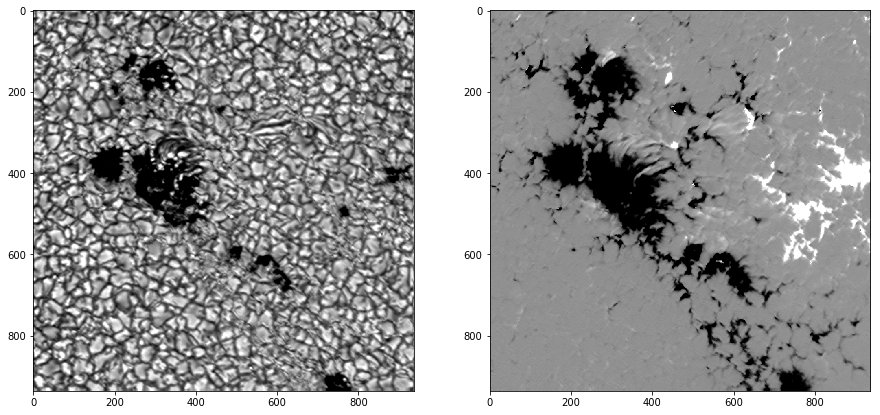

In [2]:
## loading data
p = '/home/fatima/Desktop/project_2/alignment/'
imax = np.flipud(pyfits.getdata(p+'imax_007.fits'))   # loading the IMaX brightness image
B = np.flipud(pyfits.getdata(p+'B_los_007.fits'))     # loading the magnetic field map
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(imax, cmap='gray',vmin=imax.mean()-2*imax.std(),vmax = imax.mean()+2*imax.std())
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(B, cmap='gray',vmin=B.mean()-2*B.std(),vmax = B.mean()+2*B.std())


### A pixel by pixel scatter plot of the brightness vs magnetic field allows me to identify the region where the magnetic elements belong to. They are all the pixels with a magnetic field above 600 G. I will make a contour plot enclosing all pixels having this threshold.

In [3]:
x = np.arange(imax.shape[1])
y = np.arange(imax.shape[0])
x,y = np.meshgrid(x,y)        #making a meshgrid with the dimensions of imax image

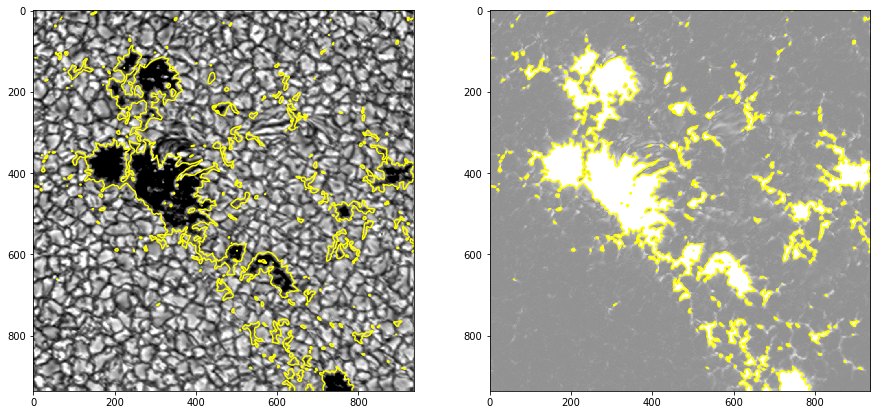

In [4]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(imax, cmap='gray',vmin=imax.mean()-2*imax.std(),vmax = imax.mean()+2*imax.std())
ax1.contour(x,y,np.abs(B),[700],colors='yellow')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(np.abs(B), cmap='gray',vmin=B.mean()-2*B.std(),vmax = B.mean()+2*B.std())
ax2.contour(x,y,np.abs(B),[700], colors='yellow')


### Since I am only interested in the magnetic elements outside bigger and darker features, I have to apply the pores mask.

In [5]:
Mask = np.flipud(pyfits.getdata(p+'Mask_pores_007.fits'))

In [6]:
# masked imax and magnetic field images
B = np.abs(B)
B2 = B*Mask
imax2 = imax*Mask

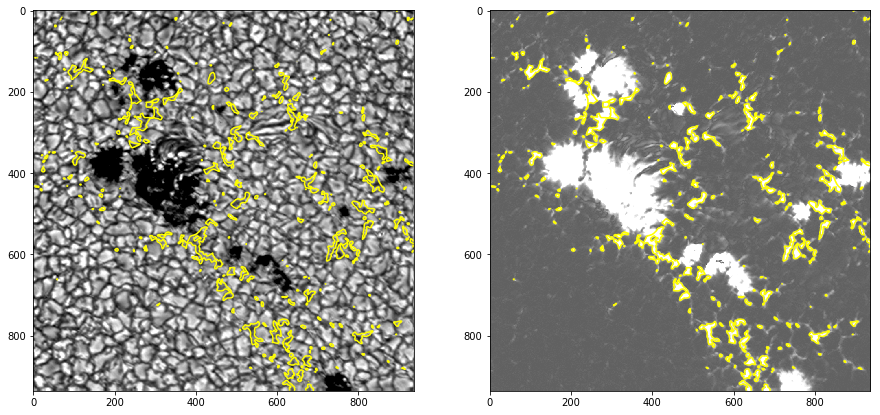

In [7]:
plt.clf()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(imax, cmap='gray',vmin=imax.mean()-2*imax.std(),vmax = imax.mean()+2*imax.std())
ax1.contour(x,y,B2,[700],colors='yellow')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(B, cmap='gray',vmin=B.mean()-2*B.std(),vmax = B.mean()+2*B.std())
ax2.contour(x,y,B2,[700], colors='yellow')


### Now you can see the contours of the small scale magnetic elements. To be able to extract individual features, I make another mask, this time of the magnetic elements. The new mask will have a value of 1 if the pixel belongs to MEs and zero if not.

In [8]:
Mask_ME = np.zeros((imax.shape[1],imax.shape[0])) 

In [9]:
for i in range(imax.shape[1]):
  for j in range(imax.shape[0]):
    if (B2[i][j]>700):
     Mask_ME[i][j]=1
    else:
     Mask_ME[i][j] = 0


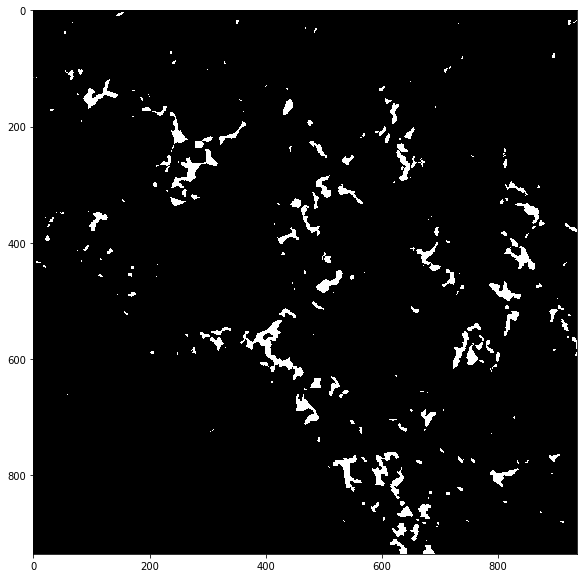

In [10]:
## showing the magnetic elements mask
plt.clf()
fig = plt.figure(figsize=(10,10))
plt.imshow(Mask_ME,cmap='gray')

### To overcome the discontinuity in the edges of the features, it is better to smooth the mask. To do this, we convolve the upper mask with a Gaussian of a certain width, in this way, the transition from features to surrounding will not be discrete, rather continuous

In [14]:
from scipy.ndimage.filters import gaussian_filter as gf
smoothed_mask = np.zeros((936,936))
boundary = 0.4
N = 3
temp = gf(Mask_ME,sigma=N,mode='nearest')
for i in range(936):
         for j in range(936):
             if temp[i][j] < boundary:

                   smoothed_mask[i][j] = 0
             else:
                   smoothed_mask[i][j] = 1
                    

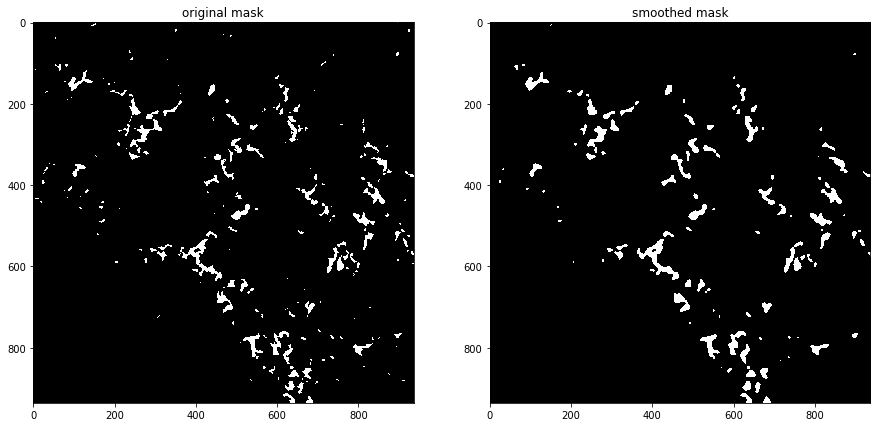

In [19]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(Mask_ME, cmap='gray')
ax1.set_title('original mask')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(smoothed_mask, cmap='gray')
ax2.set_title('smoothed mask')

### You can see that features look now smoother, we can visualize this using the module __[profile line](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.profile_line)__ in skimage to plot the intensity profile along a line.

In [20]:
import skimage
from skimage import measure

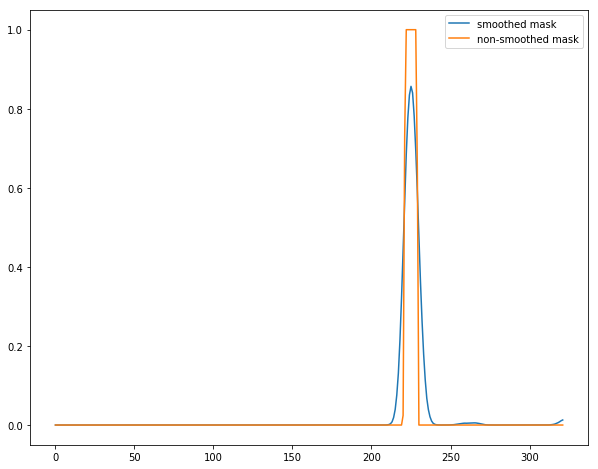

In [41]:
X  = skimage.measure.profile_line(temp,(600,700),(400,450))
Y = skimage.measure.profile_line(Mask_ME,(600,700),(400,450))
fig=plt.figure(figsize=(10,8))
plt.plot(X,label='smoothed mask')
plt.plot(Y, label='non-smoothed mask')
plt.legend()

### The profiles look broader in the smoothed mask, removing this way the discontinuities in the features. Now that we have our features as a mask, we can use the module __[label](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label)__ to identify the features and give each one a specific label.

In [42]:
labels, numb = measure.label(smoothed_mask,background=0, return_num=True)

# background is set to zero to tell label that we are not interested in such pixels
# there is an option to return the number of features which is set to True

### We can also use imshow to see how label works:

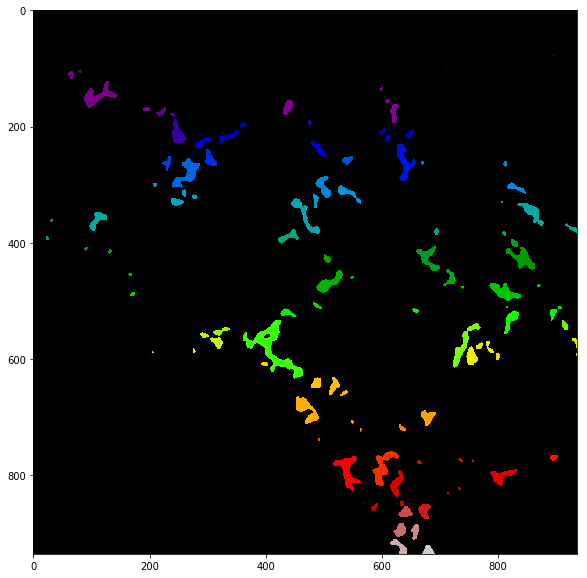

In [123]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(labels, cmap='spectral')


### One can see in this way how features are classified (according to color). We can also plot the features:

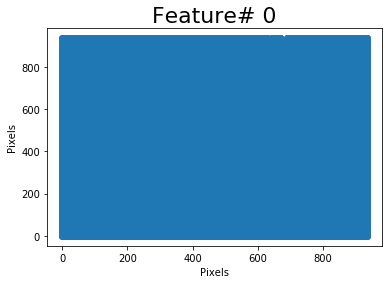

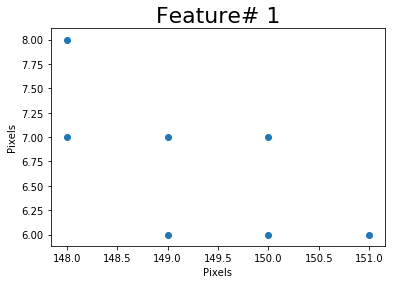

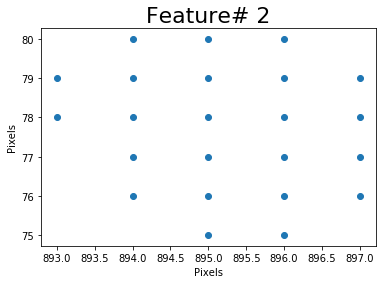

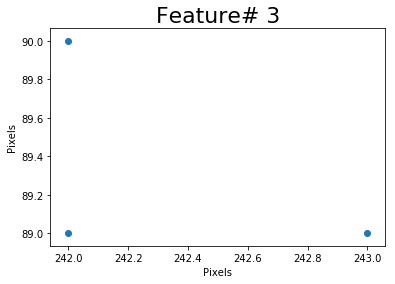

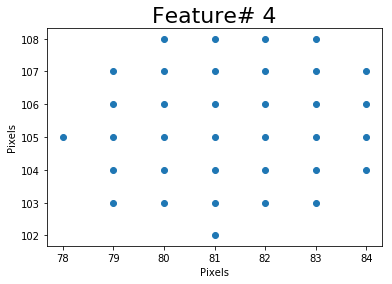

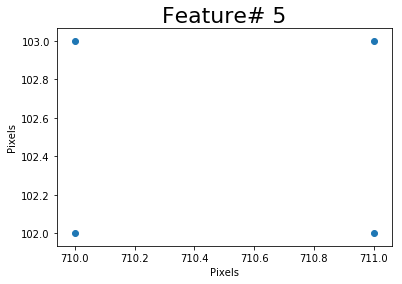

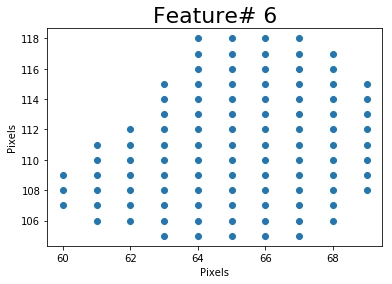

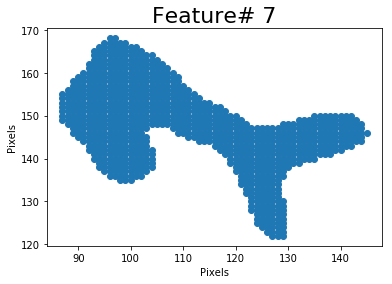

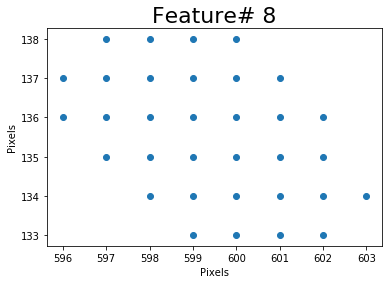

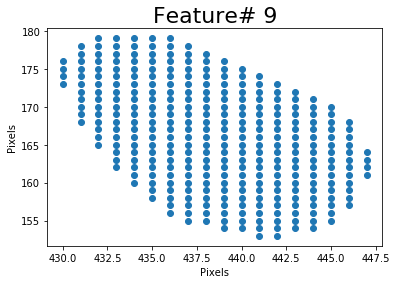

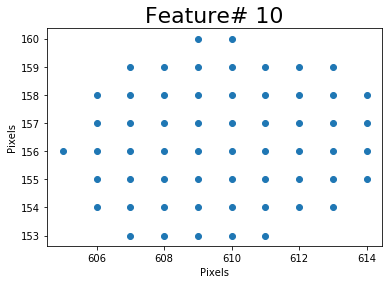

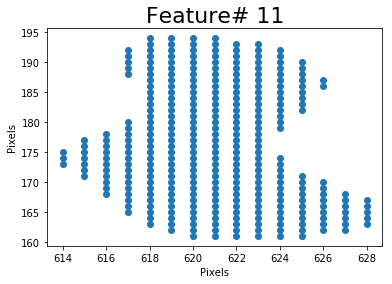

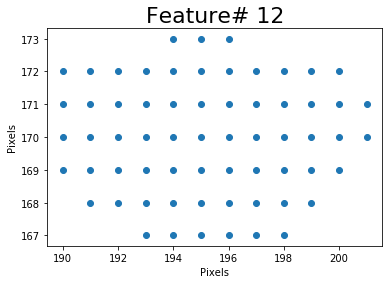

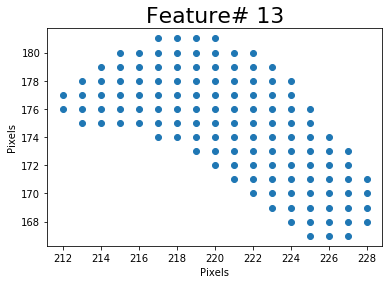

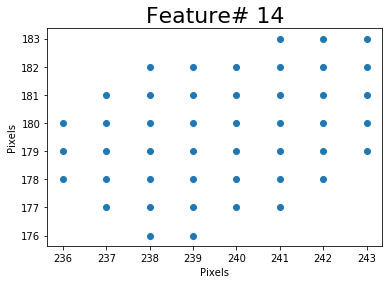

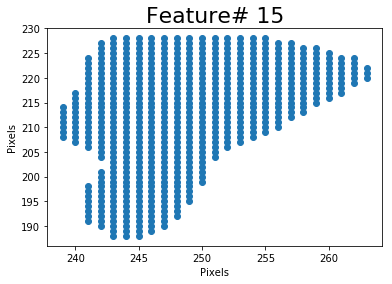

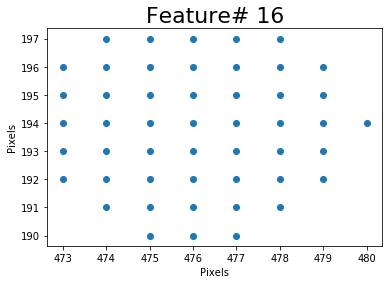

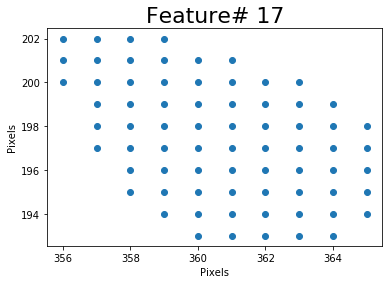

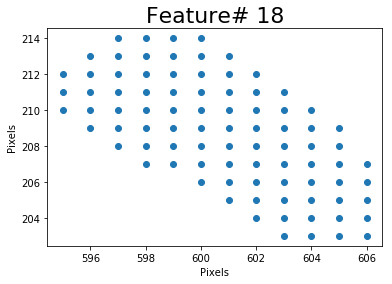

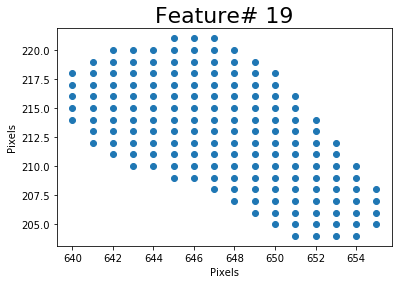

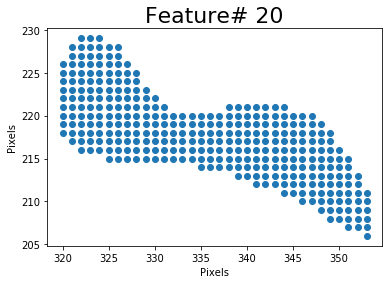

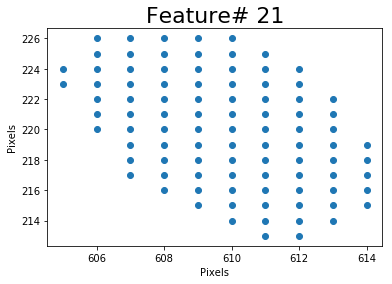

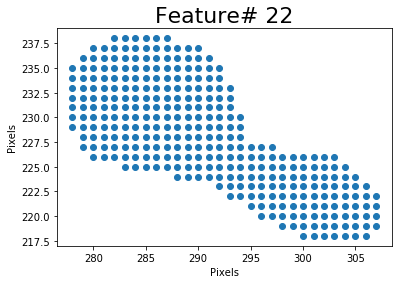

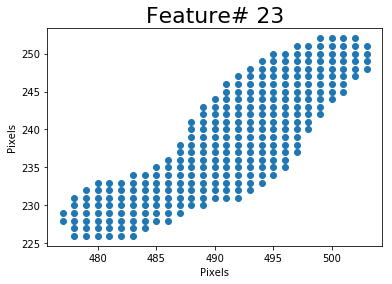

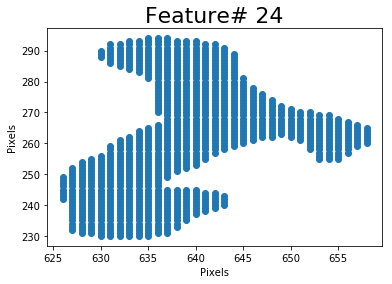

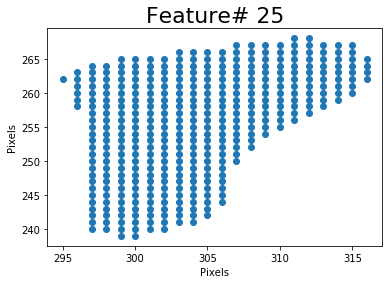

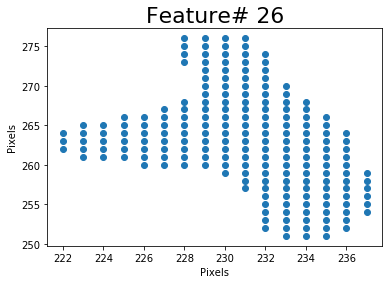

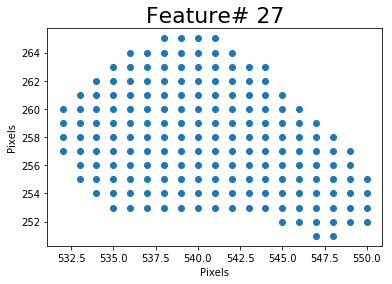

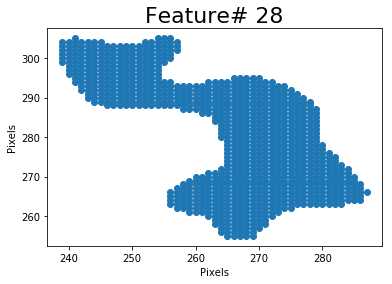

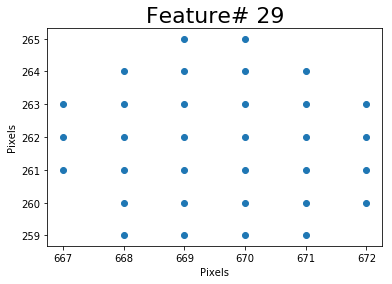

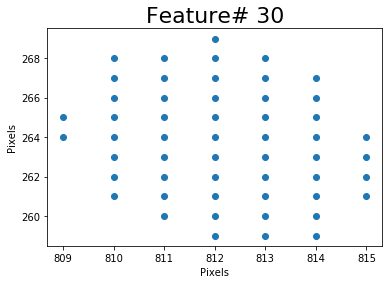

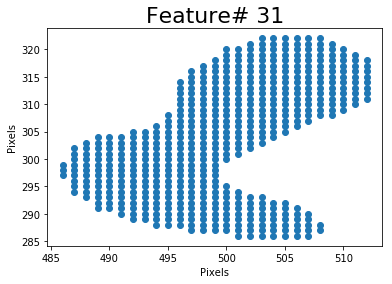

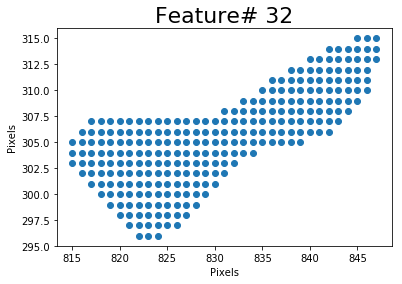

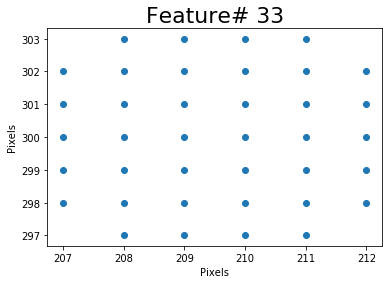

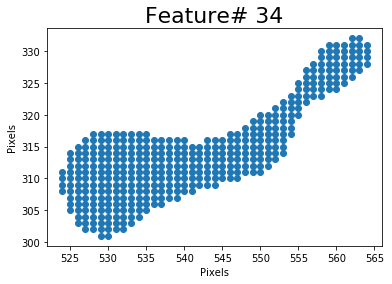

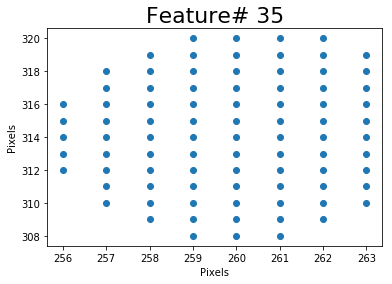

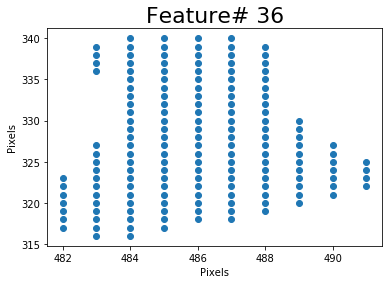

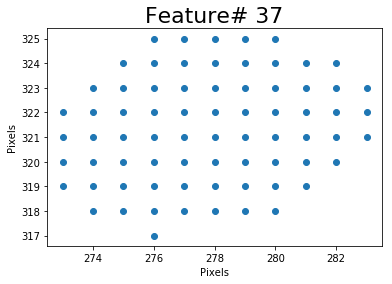

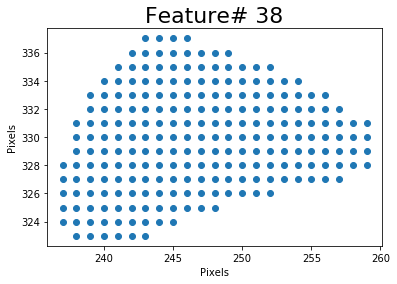

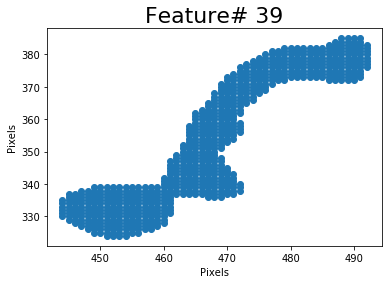

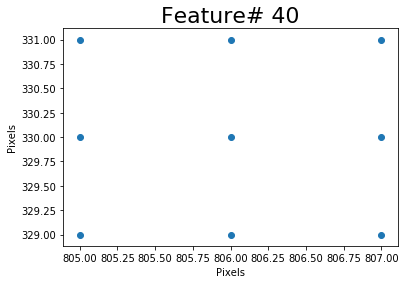

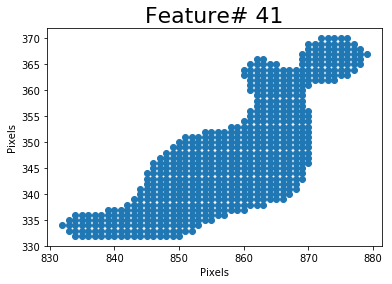

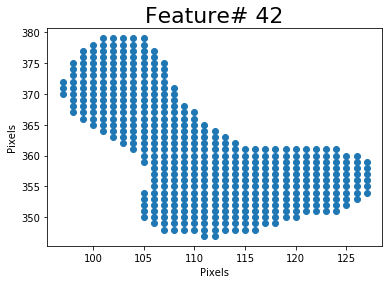

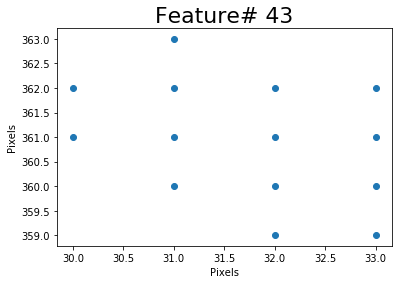

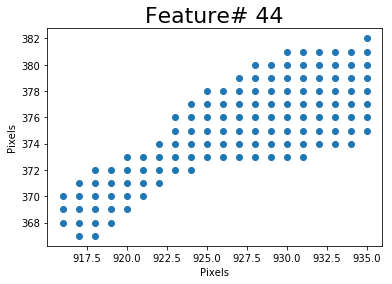

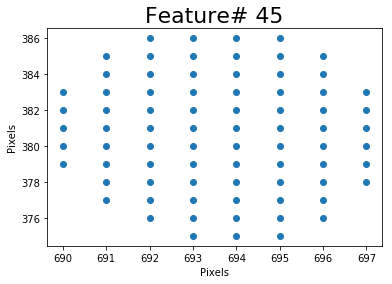

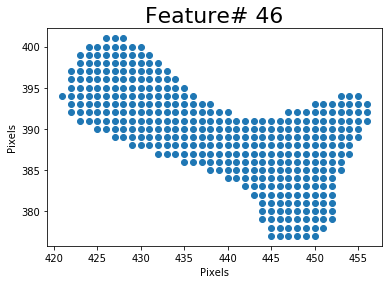

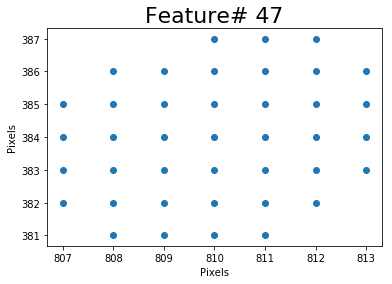

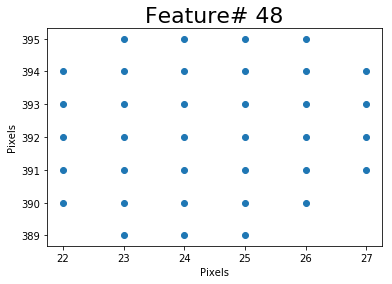

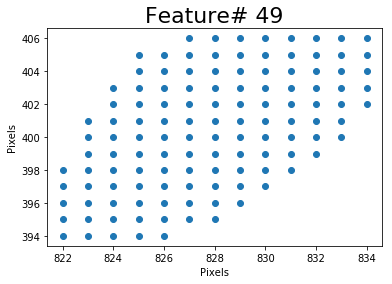

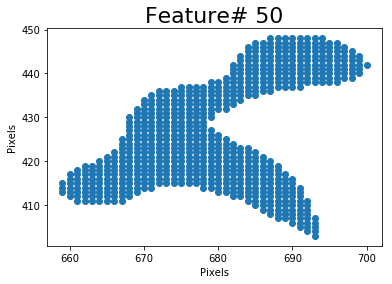

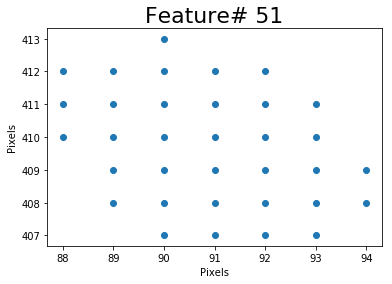

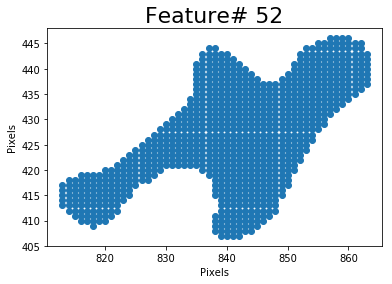

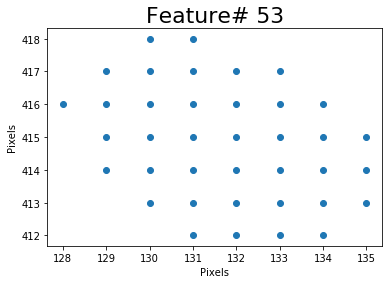

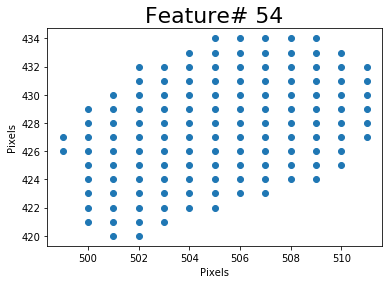

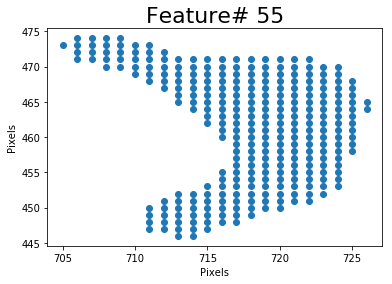

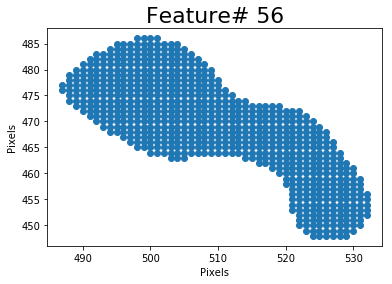

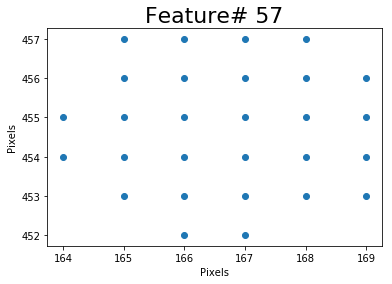

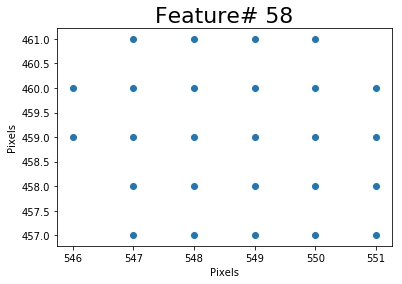

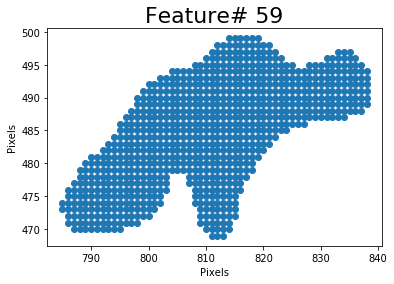

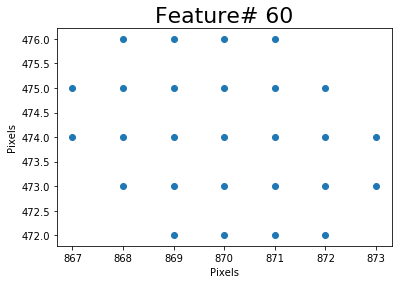

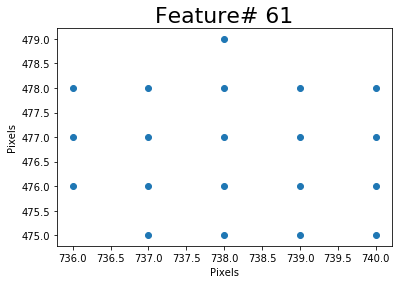

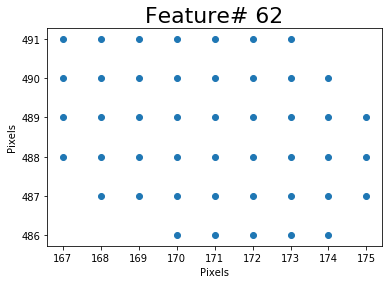

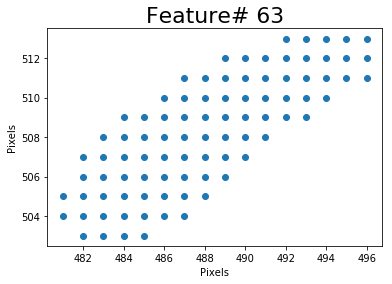

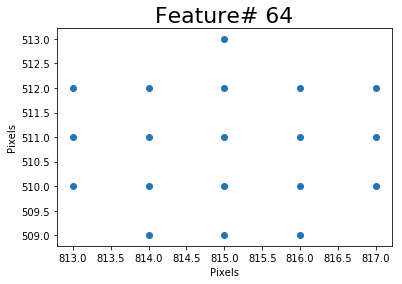

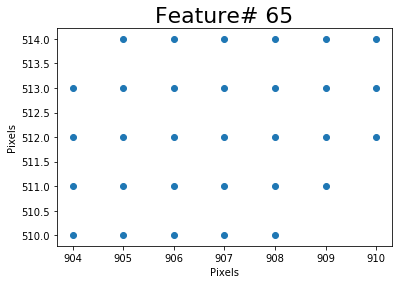

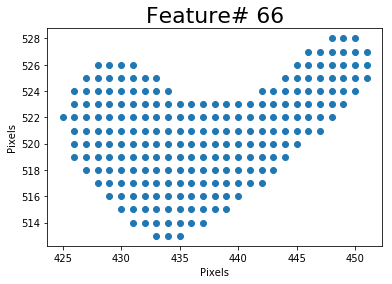

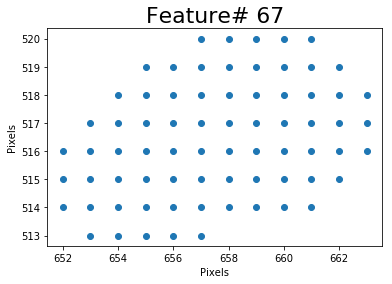

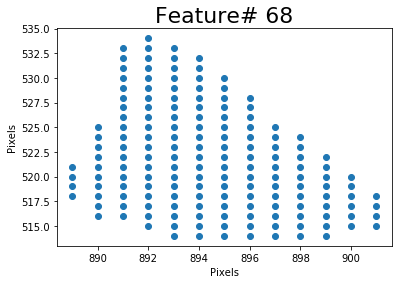

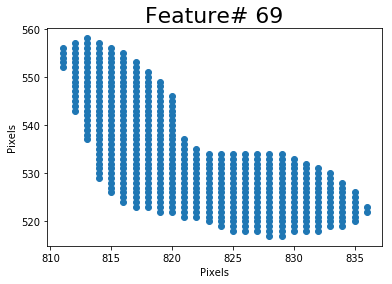

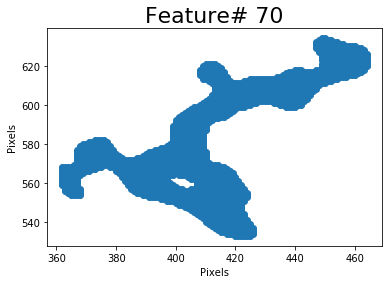

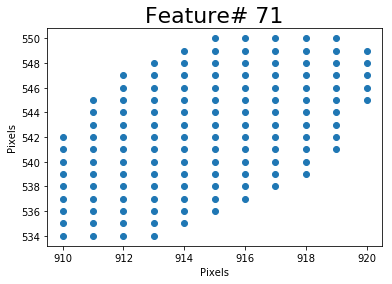

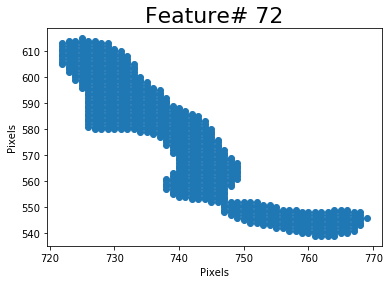

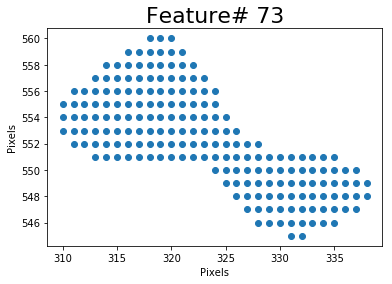

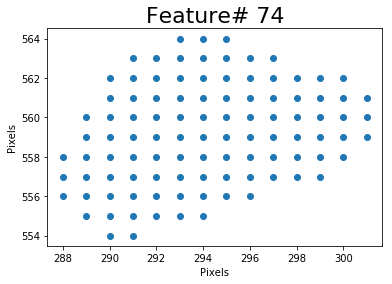

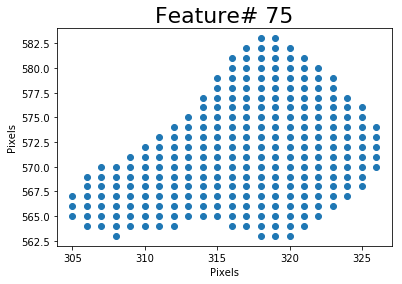

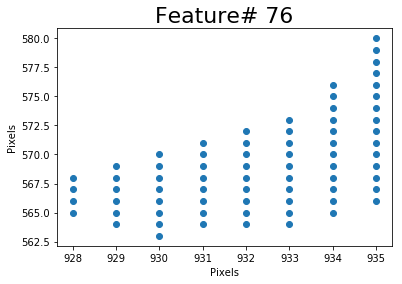

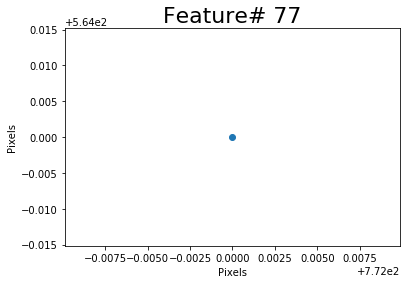

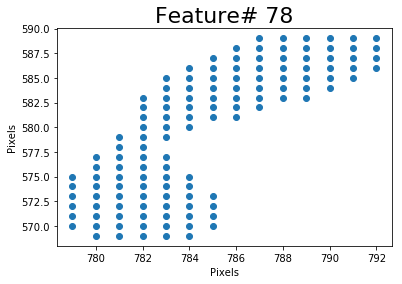

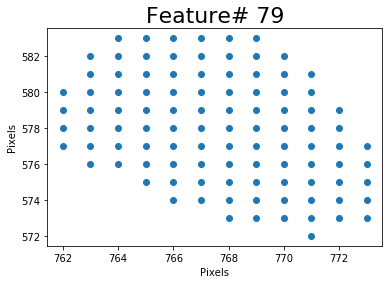

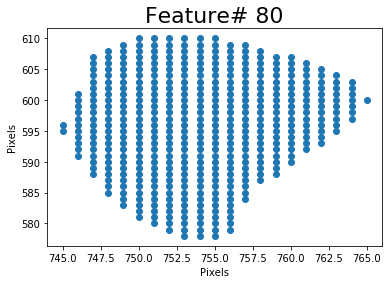

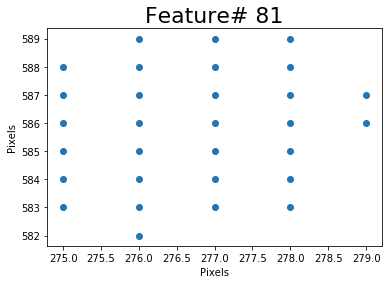

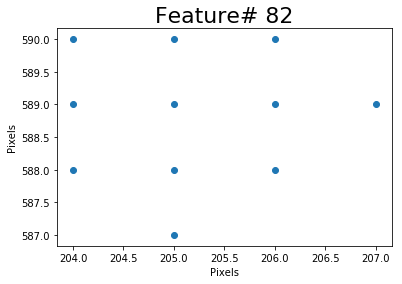

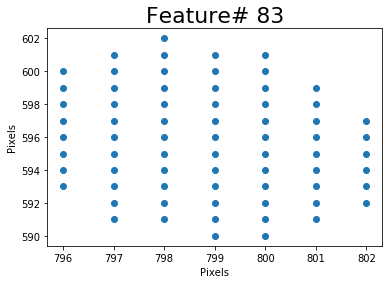

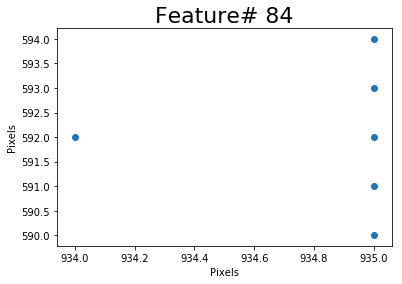

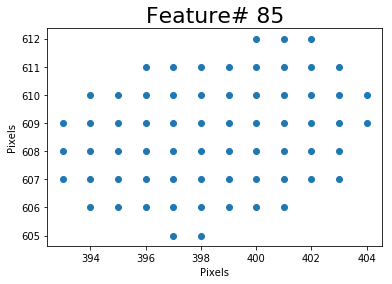

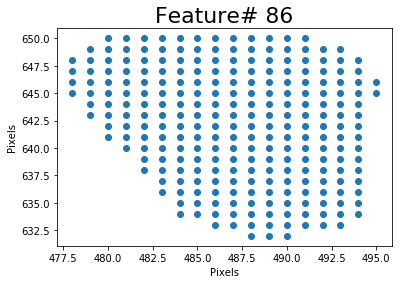

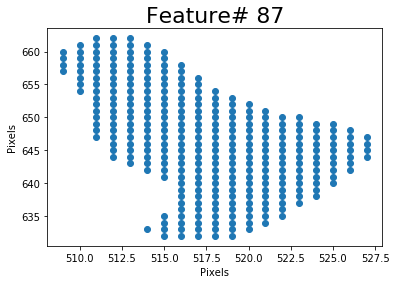

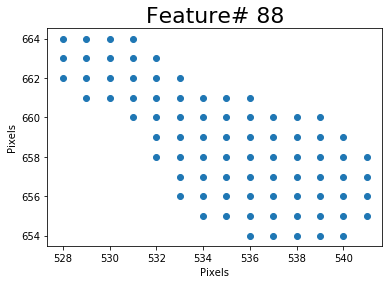

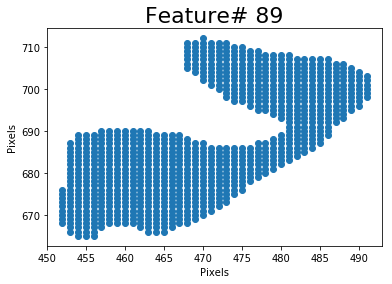

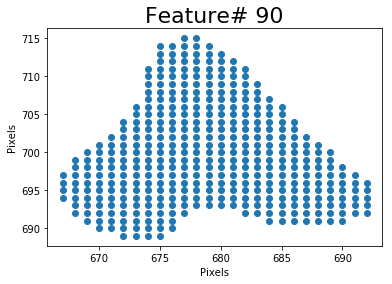

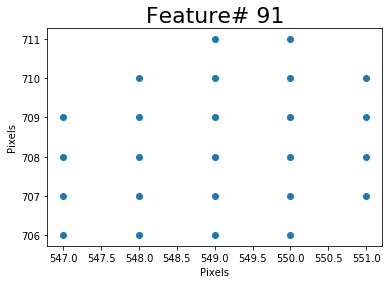

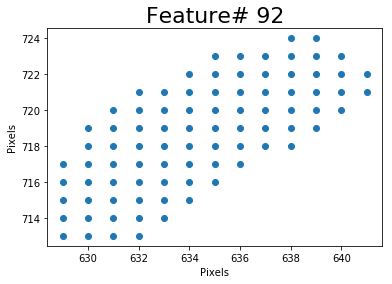

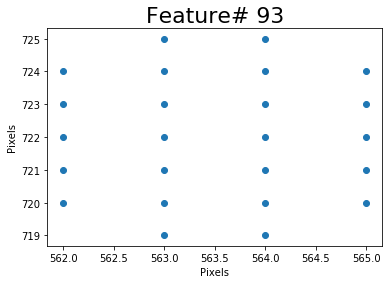

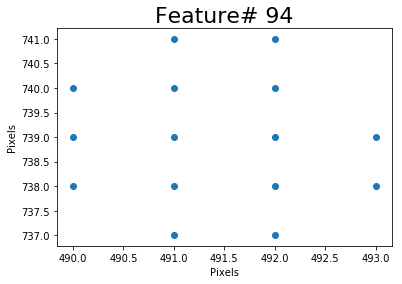

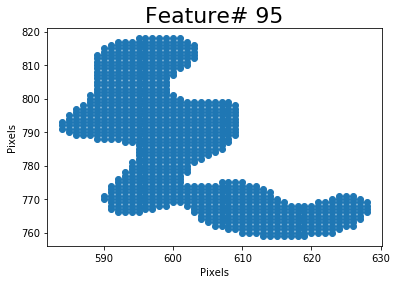

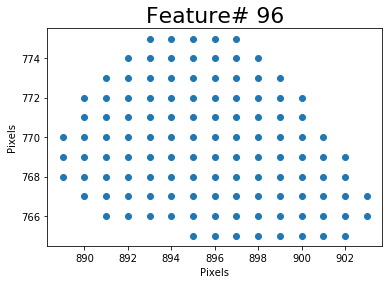

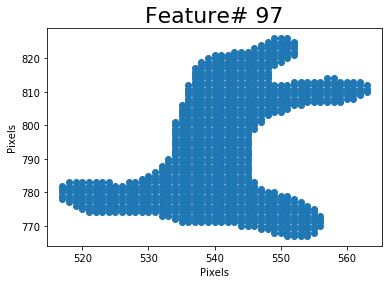

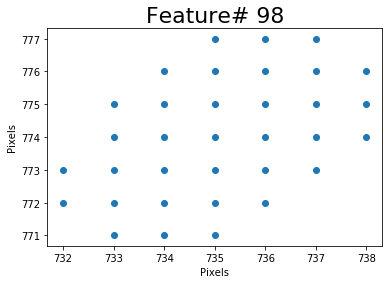

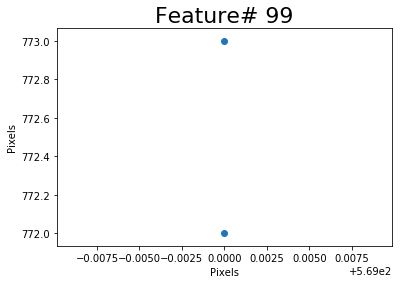

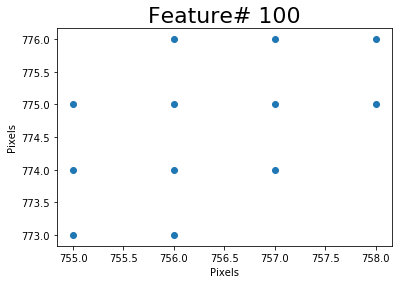

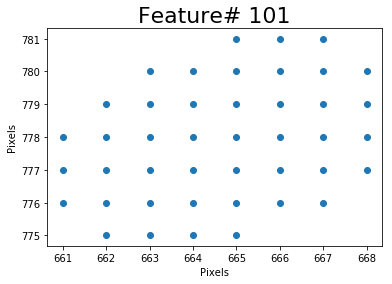

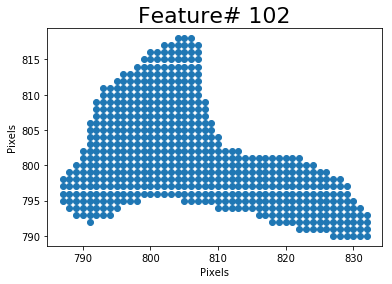

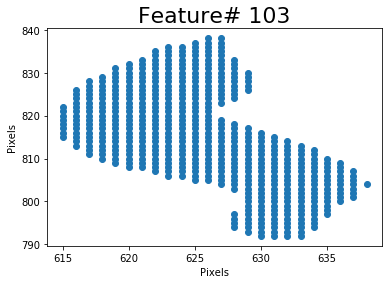

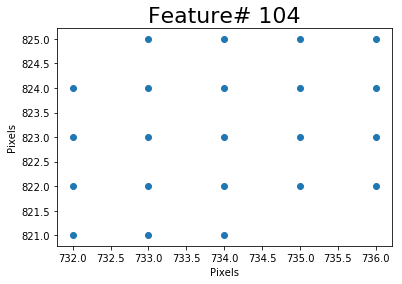

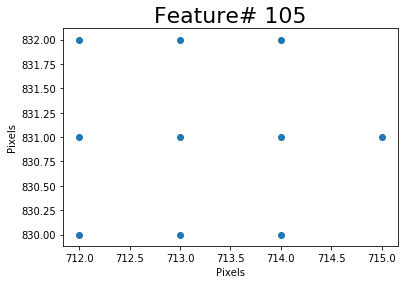

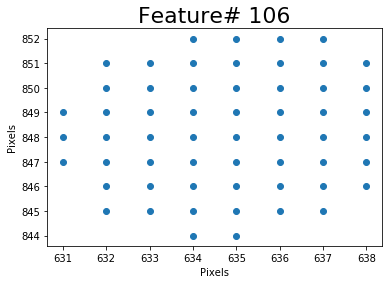

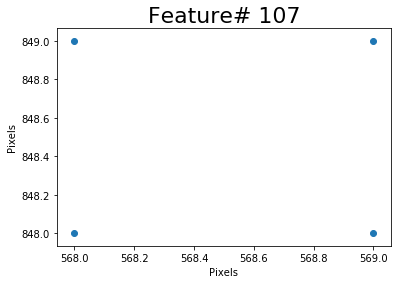

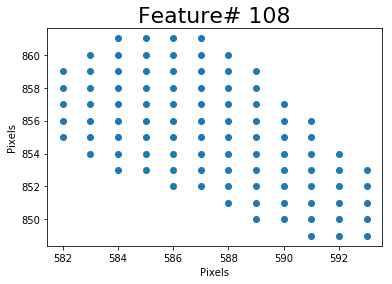

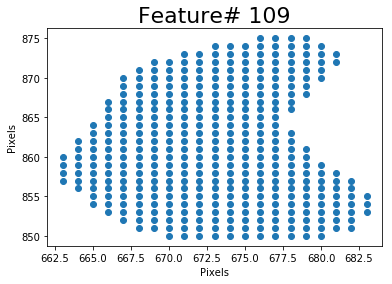

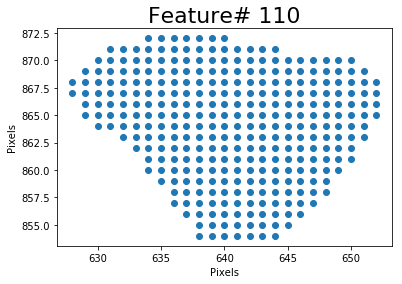

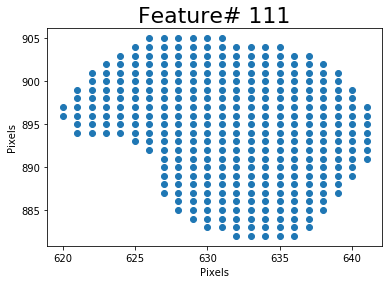

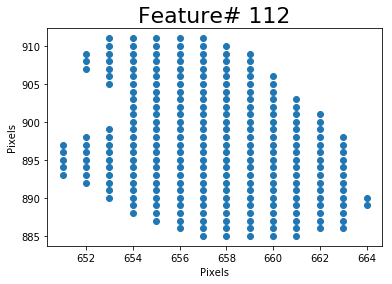

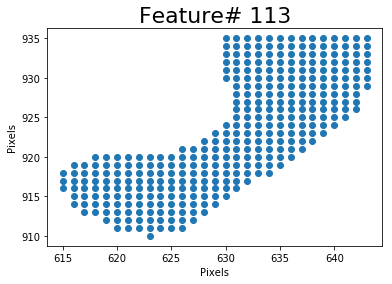

In [124]:
## the first label correspond to the background
for label in np.arange(numb):
    t = np.where(labels==label)
    plt.scatter(t[1],t[0])
    plt.title('Feature# '+str(label),fontsize=22)
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')
    #plt.savefig('feature_'+str(label)+'.png')
    plt.show()


### Some features are actually very small and might not be needed for the analysis, to remove them, we can use the module __[skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)__

In [43]:
from skimage import morphology

In [44]:
labels_no_small = skimage.morphology.remove_small_objects(labels,min_size=10)
## min_size means that we only want features above this threshold (given in pixels)

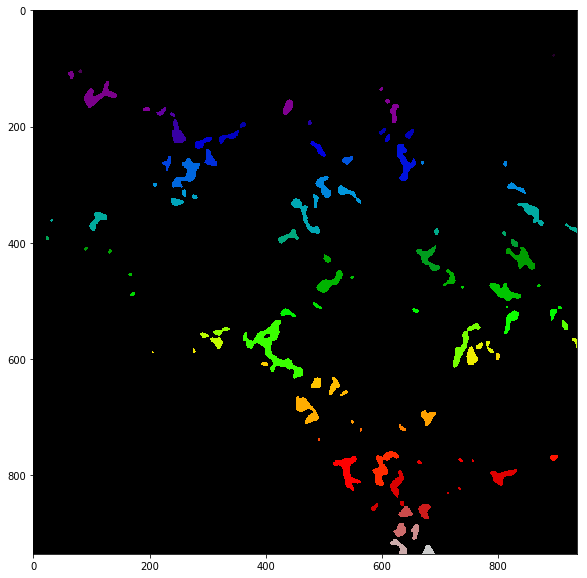

In [46]:
## We plot the label image again to see which features are gone
plt.clf()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(labels_no_small, cmap='spectral')

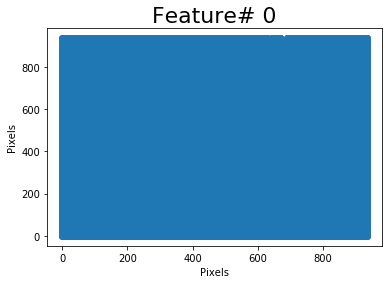

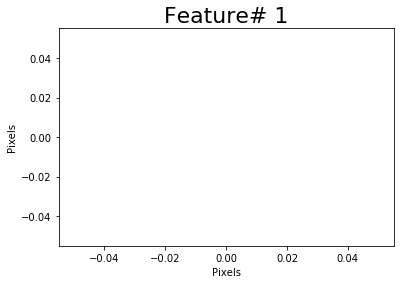

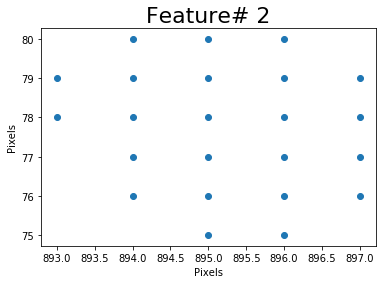

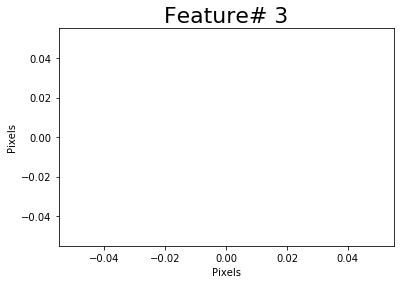

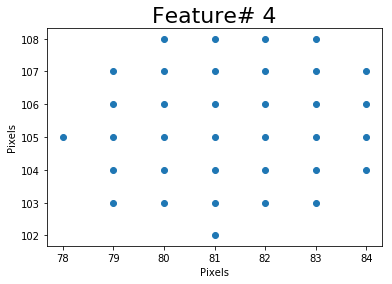

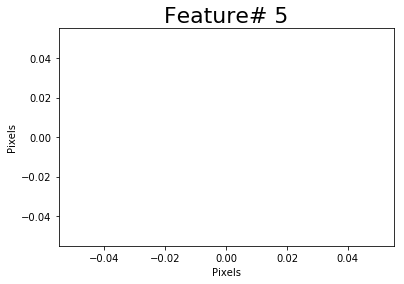

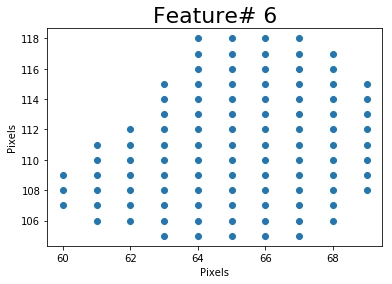

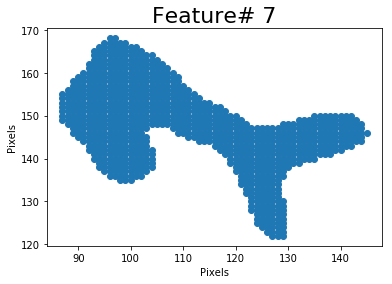

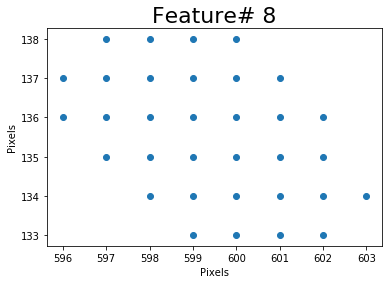

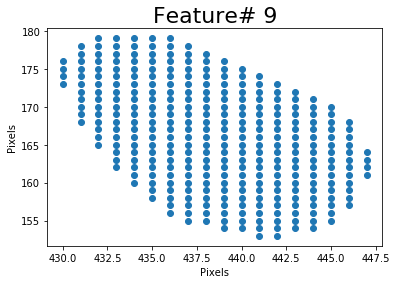

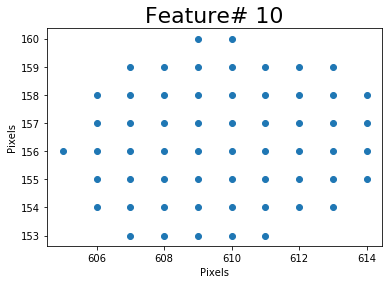

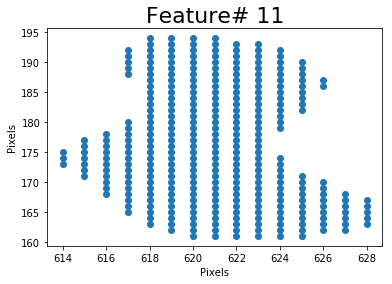

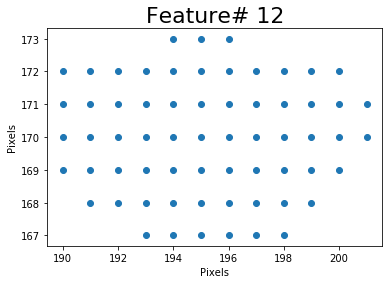

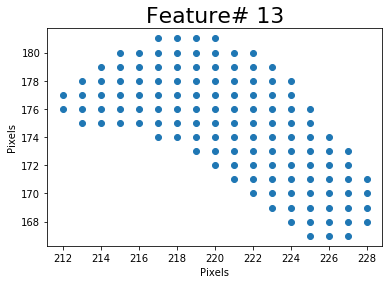

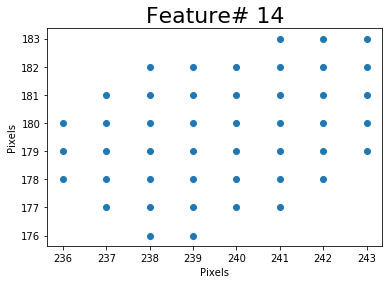

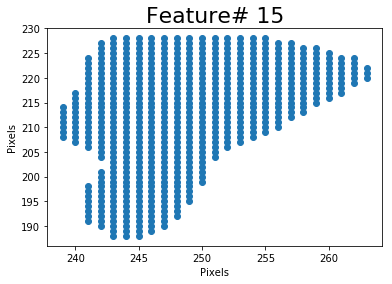

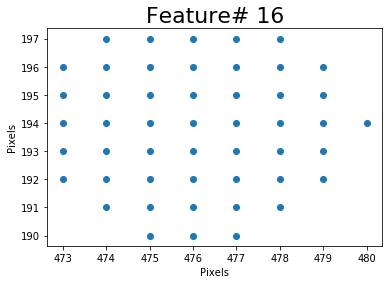

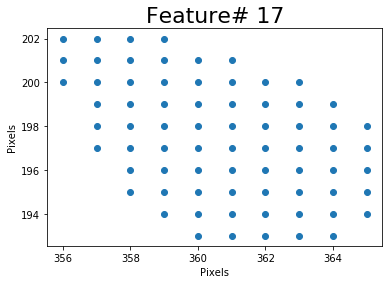

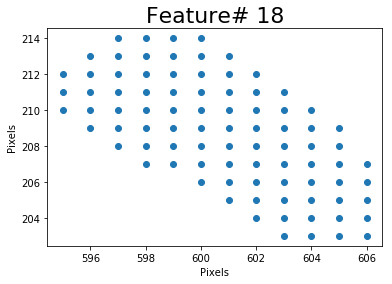

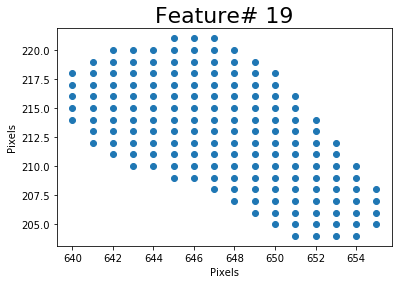

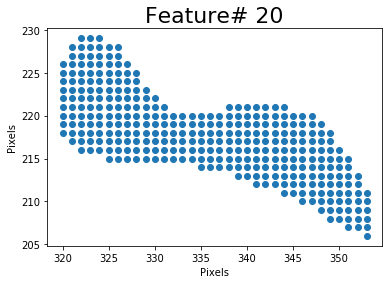

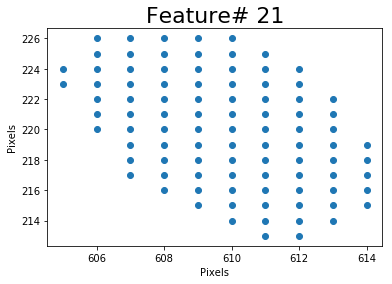

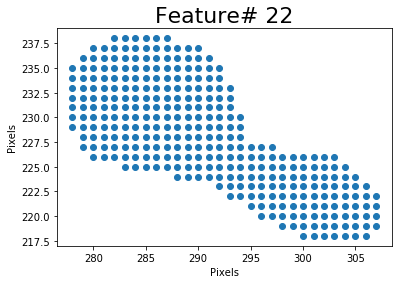

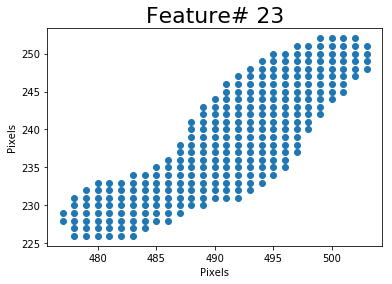

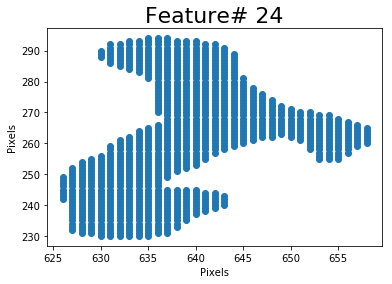

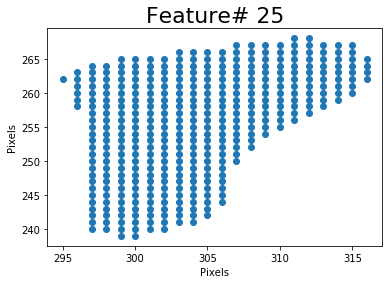

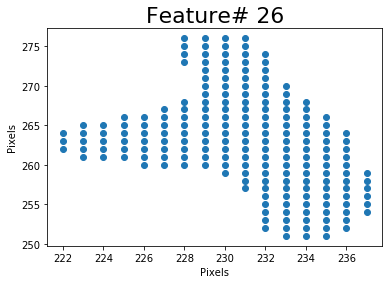

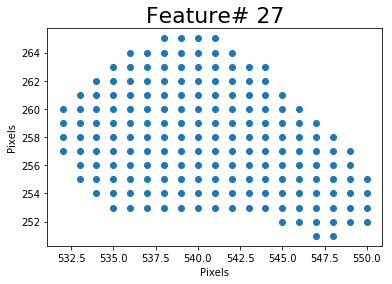

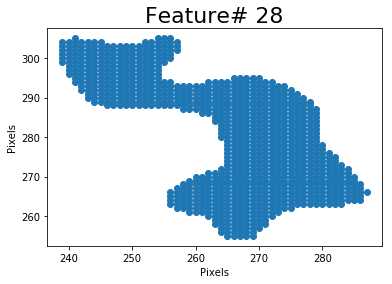

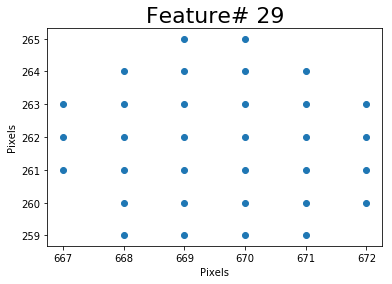

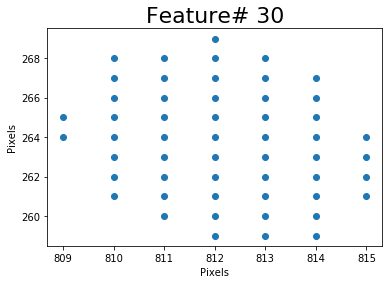

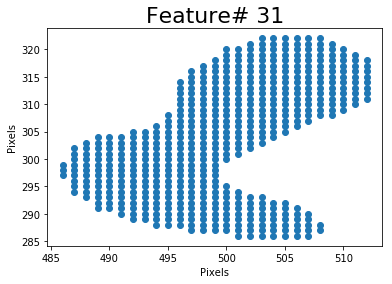

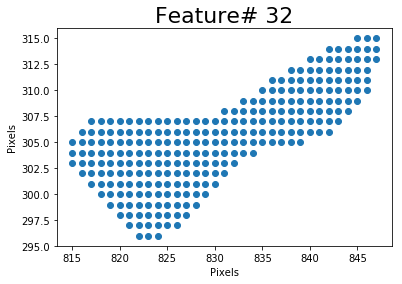

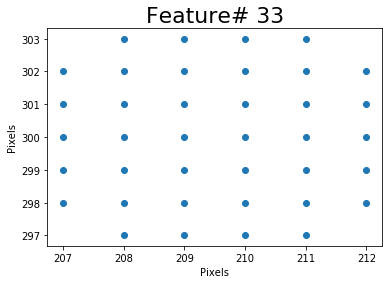

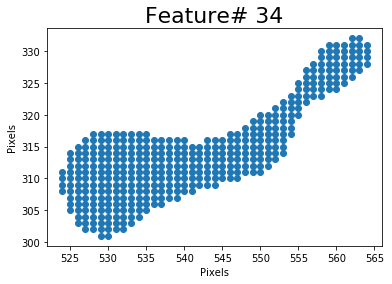

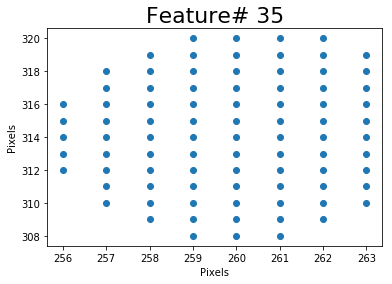

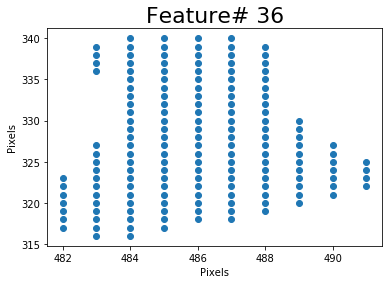

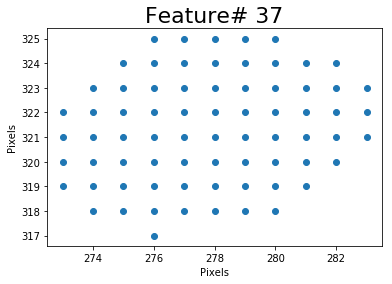

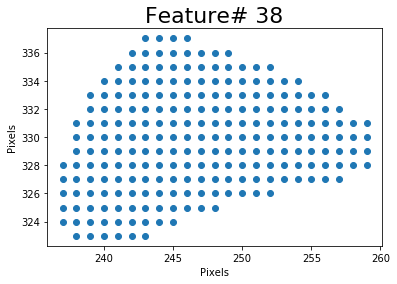

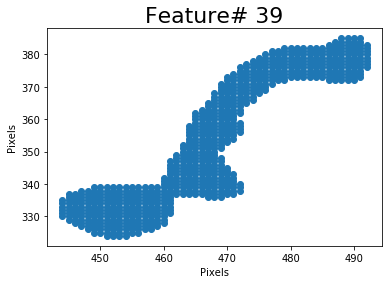

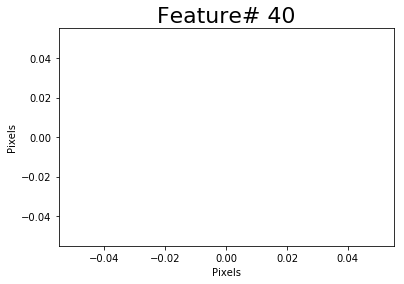

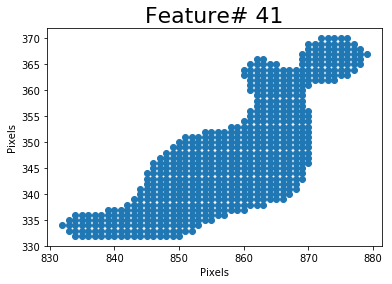

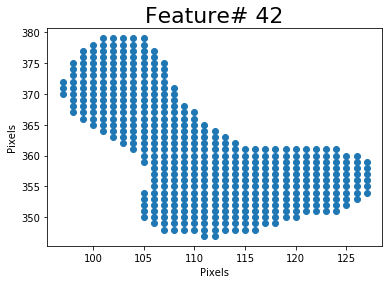

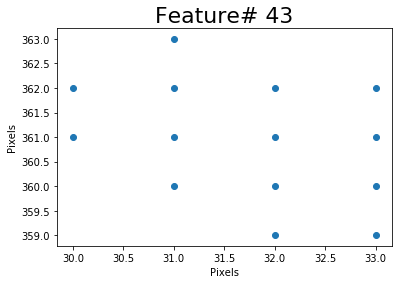

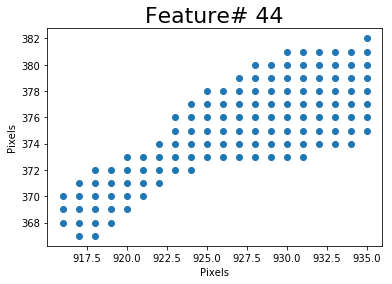

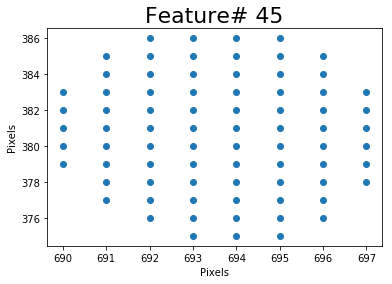

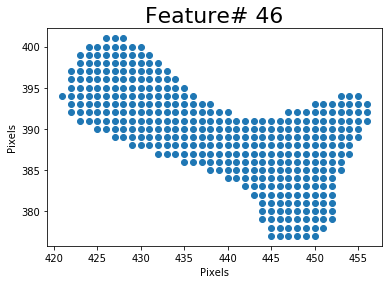

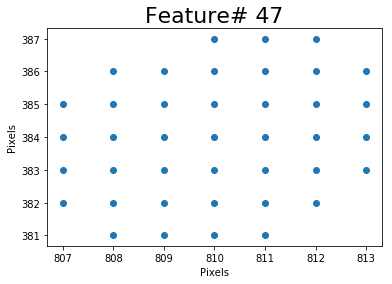

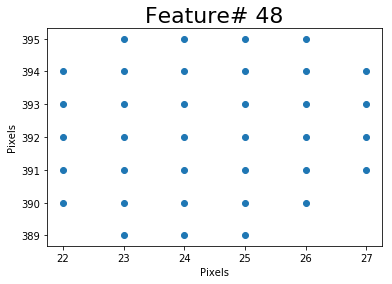

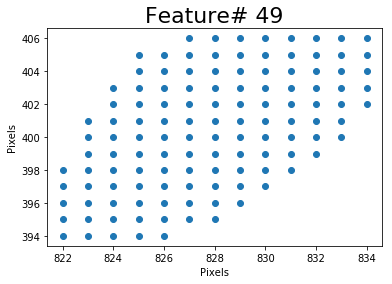

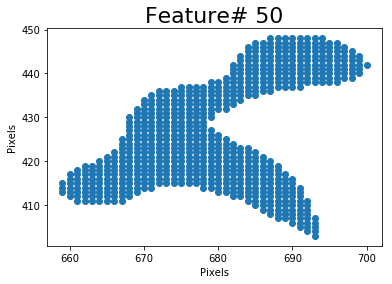

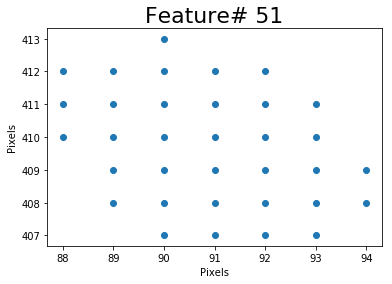

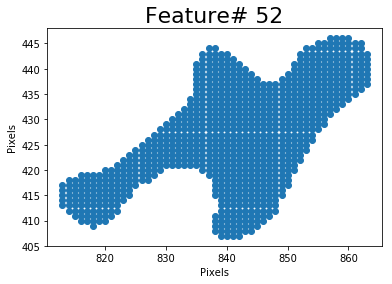

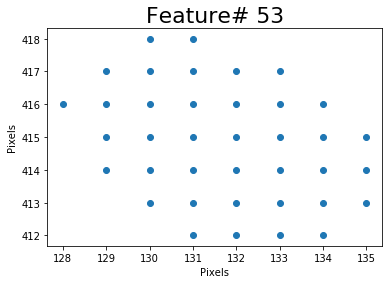

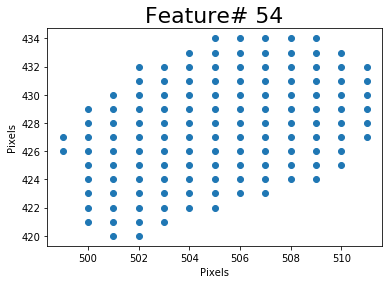

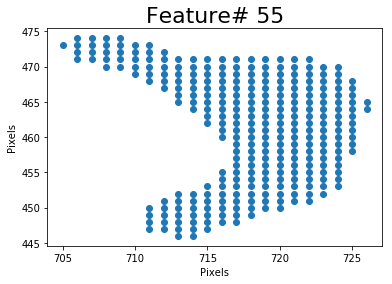

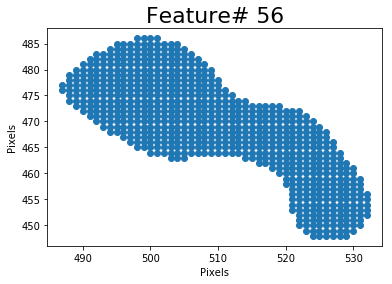

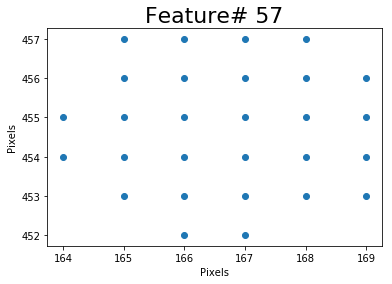

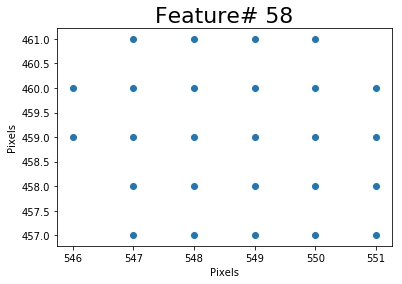

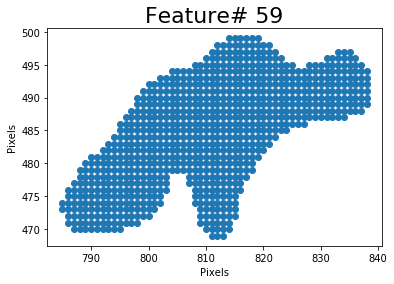

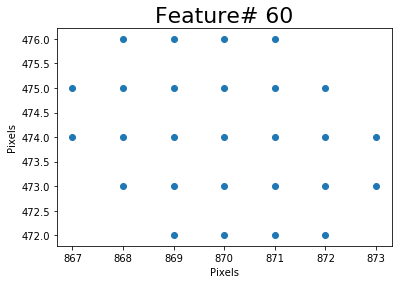

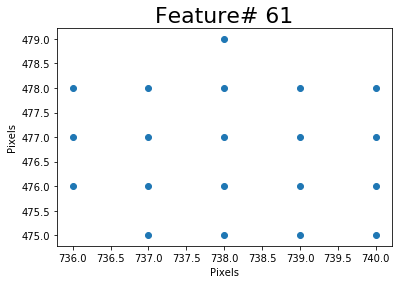

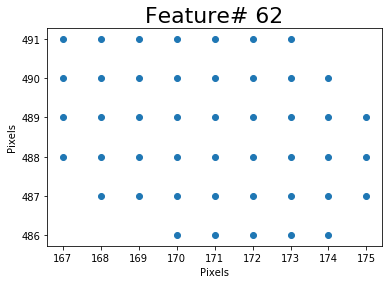

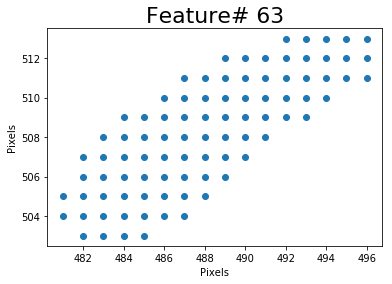

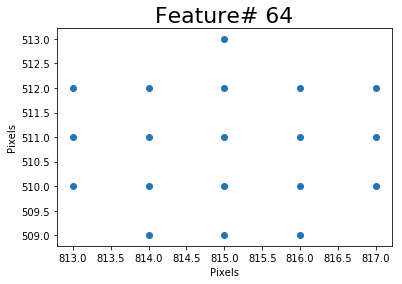

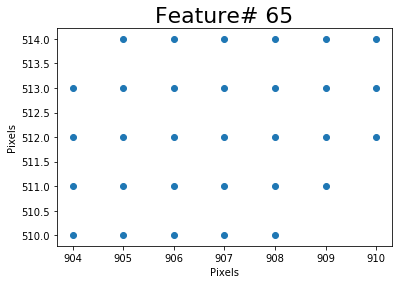

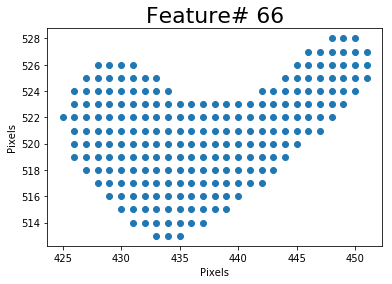

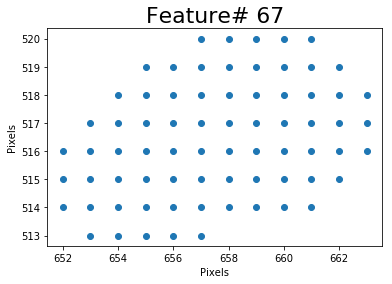

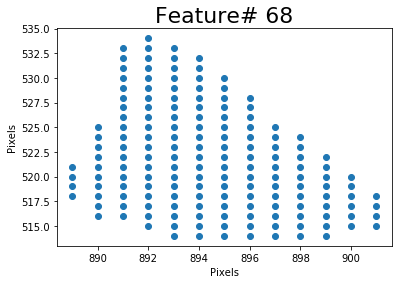

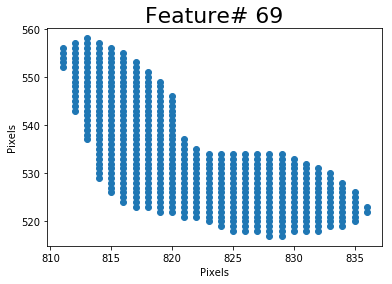

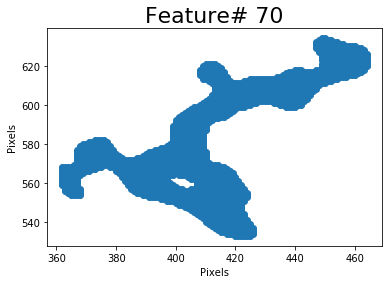

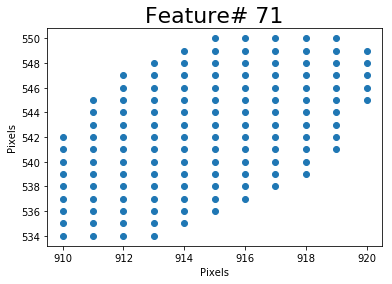

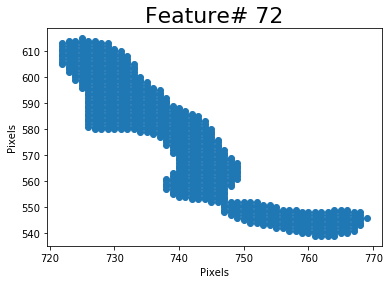

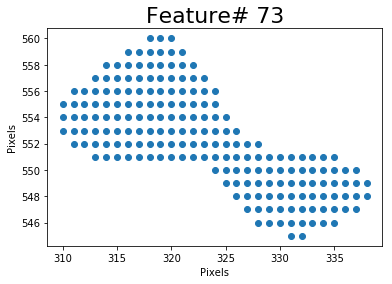

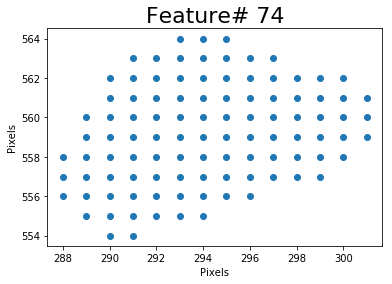

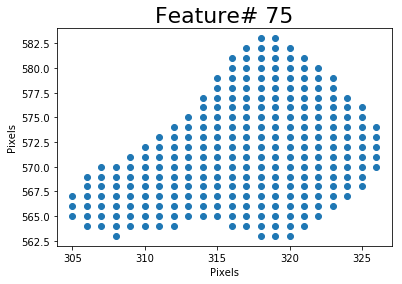

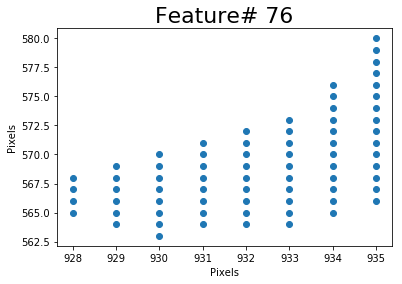

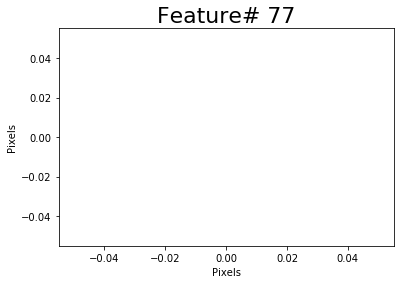

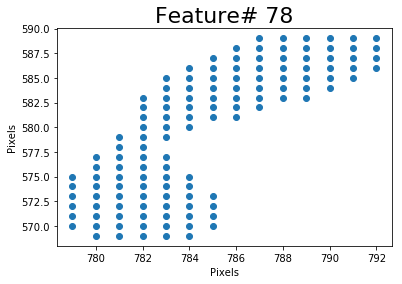

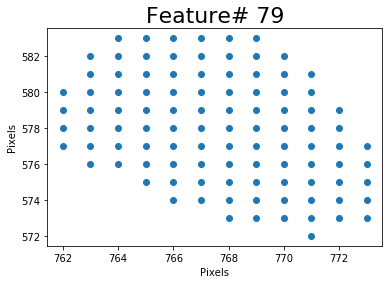

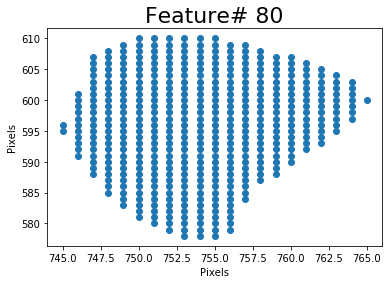

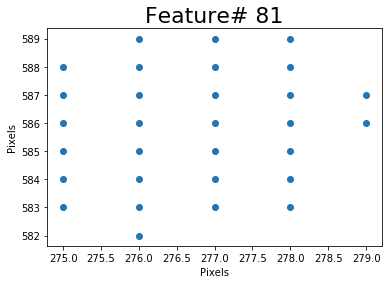

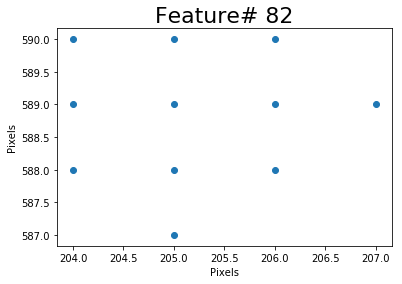

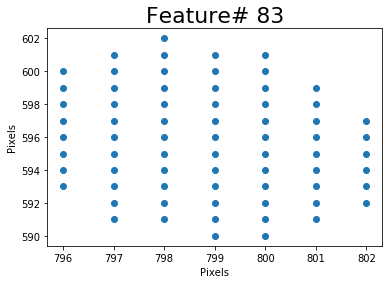

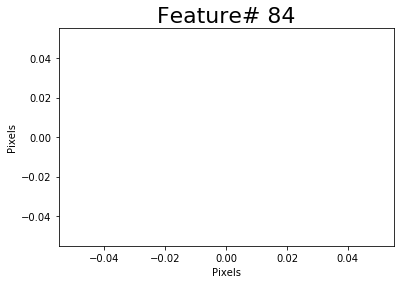

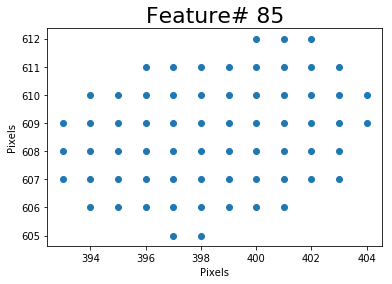

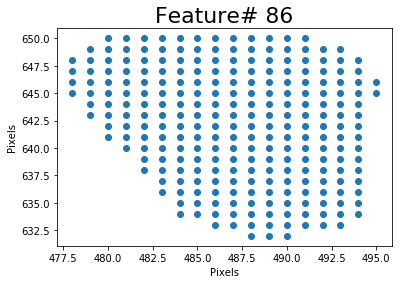

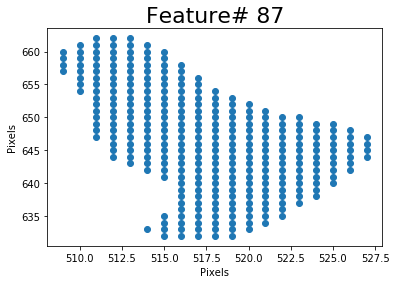

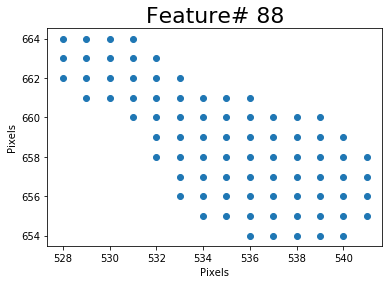

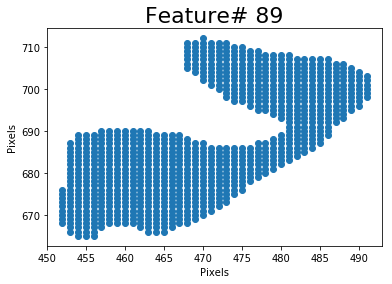

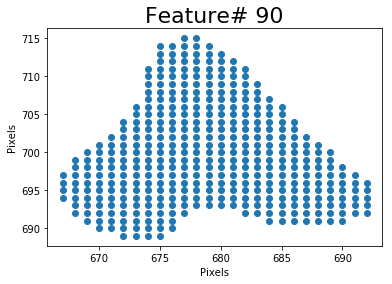

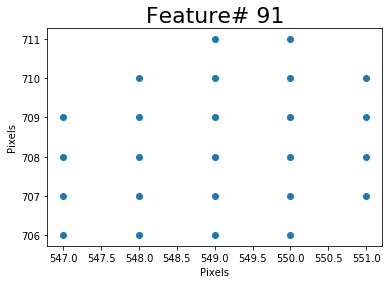

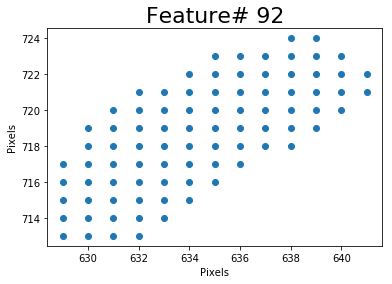

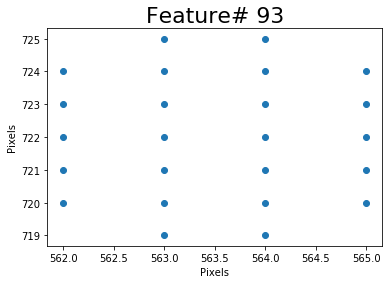

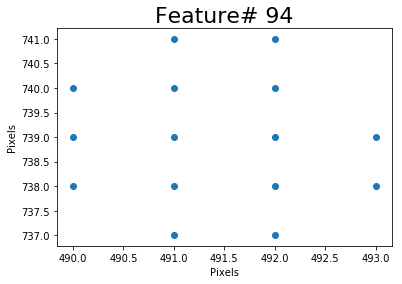

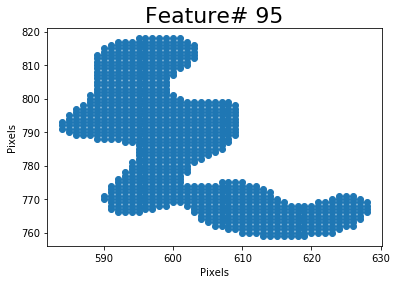

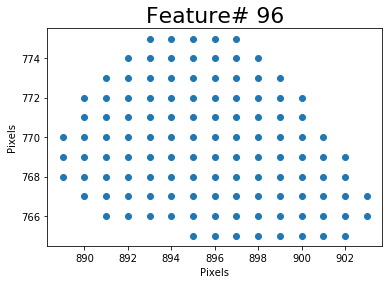

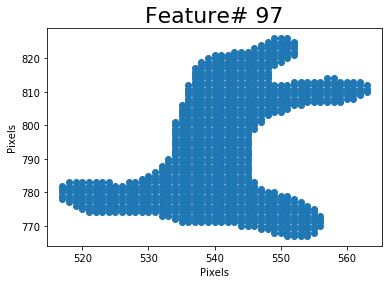

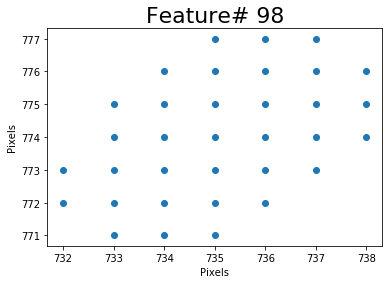

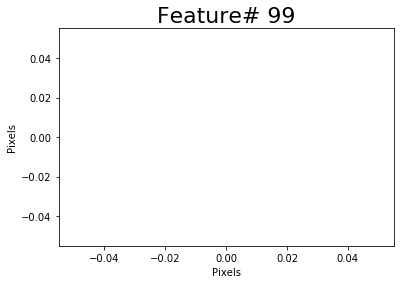

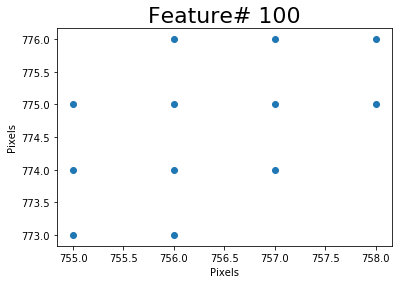

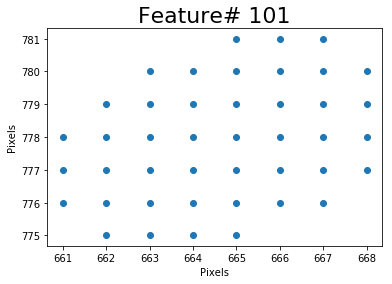

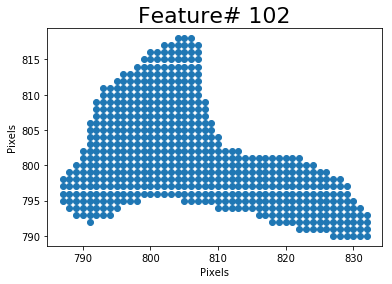

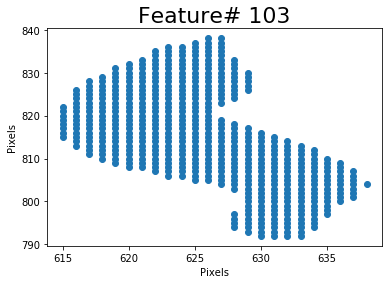

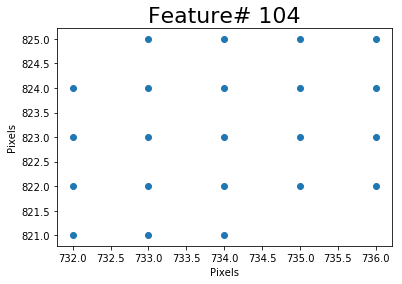

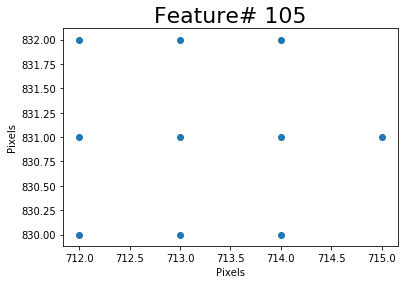

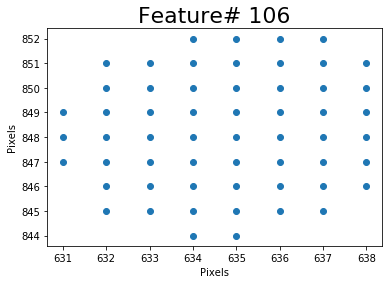

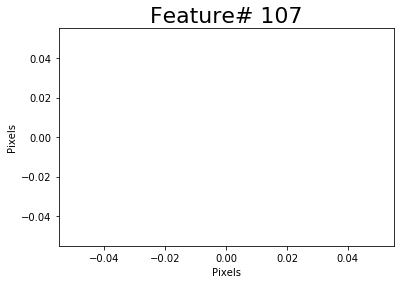

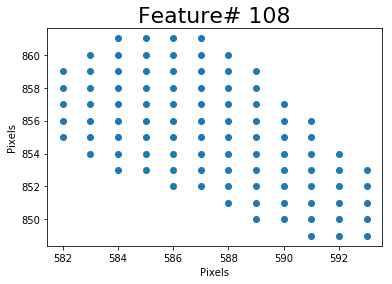

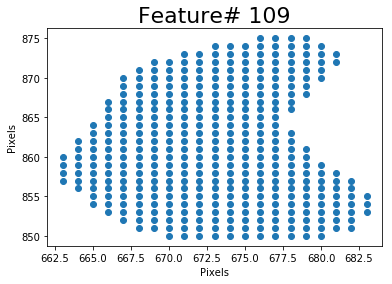

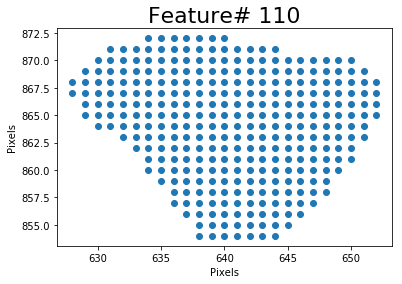

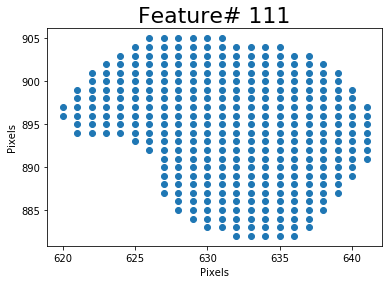

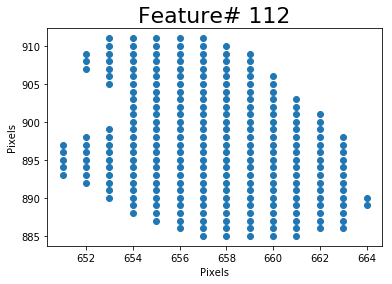

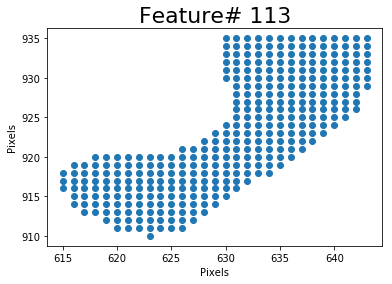

In [128]:
## better to re-plot the features
for label in np.arange(numb):
    t = np.where(labels_no_small==label)
    plt.scatter(t[1],t[0])
    plt.title('Feature# '+str(label),fontsize=22)
    plt.xlabel('Pixels')
    plt.ylabel('Pixels')
    #plt.savefig('feature_'+str(label)+'.png')
    plt.show()


### If you compare between the features after removing the small objects (with size less than 10 pixels), you can see that they were actually removed from the label image (for example features 3 and 5).

### Now let's move to the important stuff! skimage has tools to measure a variety of region properties of the segmented features. For an overview, check __[regionprops](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops)__.

In [47]:
from skimage.measure import regionprops

In [48]:
props = skimage.measure.regionprops(labels_no_small, intensity_image=imax2)
# here I implement an intensity image because I would like to measure the brightness of features

In [49]:
# I am interested in correlating the area with the brightness and magnetic field strength
props_b = skimage.measure.regionprops(labels_no_small, intensity_image=np.abs(B2))
areas = np.array([prop.area for prop in props])
brightness = np.array([prop.mean_intensity for prop in props])
field = np.array([prop.mean_intensity for prop in props_b])

In [50]:
## since I want the area in km^2, I have to use the pixel scale:
imscale = 0.05  #(arcsec/pixel)
#areas = areas * (imscale*725)**2


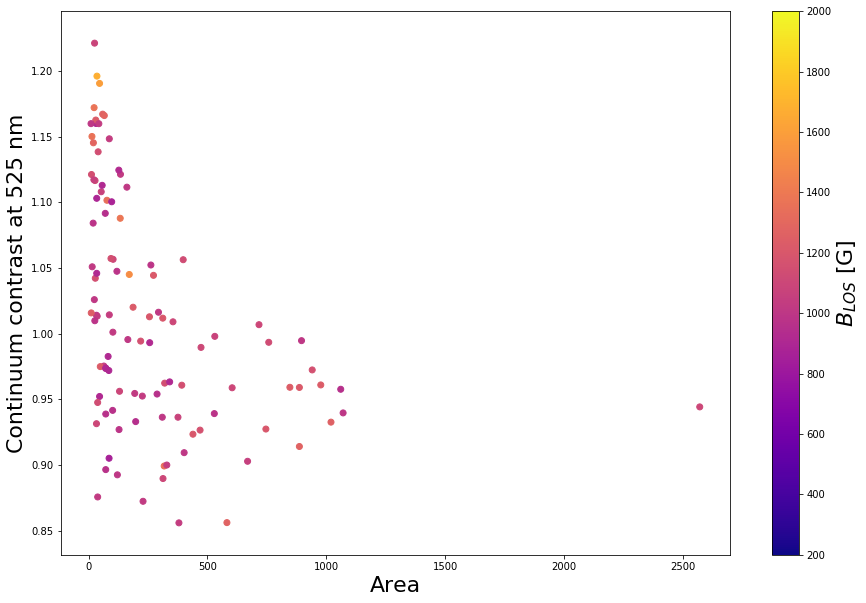

In [52]:
fig = plt.figure(figsize=(15,10))
plt.scatter(areas, brightness, c=field,cmap='plasma',vmin=200,vmax=2000)
cbar = plt.colorbar()
plt.xlabel('Area', fontsize=22)
plt.ylabel('Continuum contrast at 525 nm',fontsize=22)
cbar.set_label('$B_{LOS}$ [G]',fontsize=22)